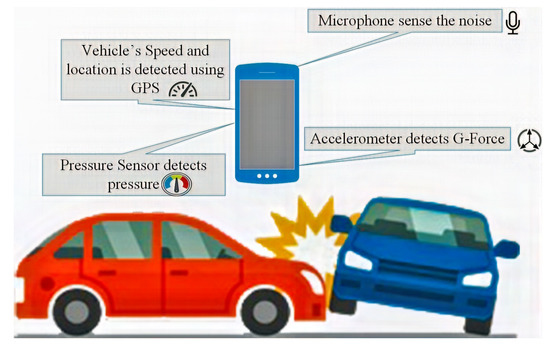

In [ ]:
import cv2
import cvzone
from ultralytics import YOLO
import os
import numpy as np


path = r"D:\Computer Vision\RoadGuard Real-Time Accident and Speed Detection System"
os.chdir(path)

from tracker import Tracker  


    
# Model
model = YOLO(r"best (1).pt")


# Data
df = open(r"coco1.txt", "r")
classes = df.read().split("\n")


cap = cv2.VideoCapture(r"cr.mp4")



prev_centers = {}  # Store the previous centers of detected vehicles
prev_times = {}    # Store the previous timestamps of detected vehicles
prev_speeds = {}   # Store the previous speeds of detected vehicles
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
distance_conversion_factor = 0.05  # Conversion factor from pixels to meters



# Calculate Euclidean Distance
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


# Calculate Speed
def calculate_speed(center, id, timestamp):
    global prev_centers, prev_times

    if id in prev_centers and id in prev_times:
        distance_pixels = euclidean_distance(center, prev_centers[id])
        time_seconds = timestamp - prev_times[id]

        if time_seconds > 0 and distance_pixels > 1:
            speed_px_s = distance_pixels / time_seconds
            prev_centers[id] = center
            prev_times[id] = timestamp
            return speed_px_s

    prev_centers[id] = center
    prev_times[id] = timestamp
    return 0



while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not load frame")
        break

    frame = cv2.resize(frame, (1020, 700))
    
    # Get the timestamp for the current frame (in seconds)
    frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    timestamp = frame_number / fps

    results = model.predict(frame)

    for result in results:
        for re in result.boxes:
            x1, y1, x2, y2 = map(int, re.xyxy[0])
            if int(re.cls[0]) < len(classes):
                name = classes[int(re.cls[0])]

                ww = x2 - x1
                hh = y2 - y1
                center = ((x1 + x2) // 2, (y1 + y2) // 2)

                id = int(re.cls[0])

                # Calculate speed
                speed_px_s = calculate_speed(center=center, id=id, timestamp=timestamp)
                speed_m_s = speed_px_s * distance_conversion_factor  # Convert speed from pixels to meters
                speed_kmh = speed_m_s * 3.6  # Convert speed to km/h


                cvzone.putTextRect(frame, f" {name},Speed: {speed_kmh:.2f} km/h", (x1 + 10, y1 - 10), scale=1, thickness=1, colorR=(0, 255, 0), colorT=(0, 0, 0))
                cvzone.cornerRect(frame, (x1, y1, ww, hh), l=20, t=10, rt=2, colorR=(0, 0, 0), colorC=(0, 255, 0))

                
                if "Accident Detection !" in name:
                    cvzone.putTextRect(frame, f" {name}", (x1 + 10, y1 - 10), scale=1, thickness=1, colorR=(0, 0, 255), colorT=(0, 0, 0))
                    cvzone.cornerRect(frame, (x1, y1, ww, hh), l=20, t=10, rt=2, colorR=(0, 0, 255), colorC=(0, 0, 255))
                    

                    
    cv2.imshow("RoadGuard Real-Time Accident and Speed Detection System", frame)

    if cv2.waitKey(1) == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
